In [1]:
import sys 
sys.path.append('..')
import random
from PIL import Image
import requests
from utils import *
import yaml
from diffusers.utils import load_image, make_image_grid 
import numpy as np 
from ultralytics import YOLO
from scripts.sam_results import SAMResults
from datasets import load_dataset
import random

yaml_file = "../configs/fashion_people_detection.yml"
with open(yaml_file, "r") as f:
    config = yaml.safe_load(f)

labels_dict = config.get("names")
labels_dict_reversed = {v: k for k, v in labels_dict.items()}

In [2]:
dataset_id = "jordandavis/fashion_people_detections"

ds = load_dataset(dataset_id, split='train', trust_remote_code=True)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

In [3]:
model_path = "/home/jordan/SEGMENT/human_parsing_test/train19/weights/last.pt"
model = YOLO(model_path, task="segment")

Row Num: 372


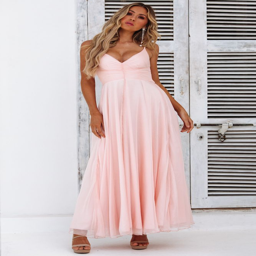

In [36]:
row_num = random.randint(0, len(ds))
print(f"Row Num: {row_num}")
row = ds[row_num]
image = row["image"]
# image = resize_image_pil(image)
image.resize((256, 256))

In [37]:
results = model(image, retina_masks=True, imgsz=1024)
result = results[0]


0: 1024x704 2 hairs, 1 face, 1 neck, 1 arm, 2 foots, 2 outfits, 2 persons, 43.7ms
Speed: 4.5ms preprocess, 43.7ms inference, 2.5ms postprocess per image at shape (1, 3, 1024, 704)


In [38]:
def unload(result):
    masks = result.masks.data
    boxes = result.boxes.xyxy
    scores = result.boxes.conf

    labels = result.boxes.cls
    labels = [int(label.item()) for label in labels]
    phrases = [labels_dict[label] for label in labels]
    return masks, boxes, scores, phrases

In [39]:
masks, boxes, scores, phrases = unload(result)

In [40]:
r = SAMResults(image, labels_dict_reversed, masks=masks, boxes=boxes, scores=scores, phrases=phrases, person_masks_only=False )

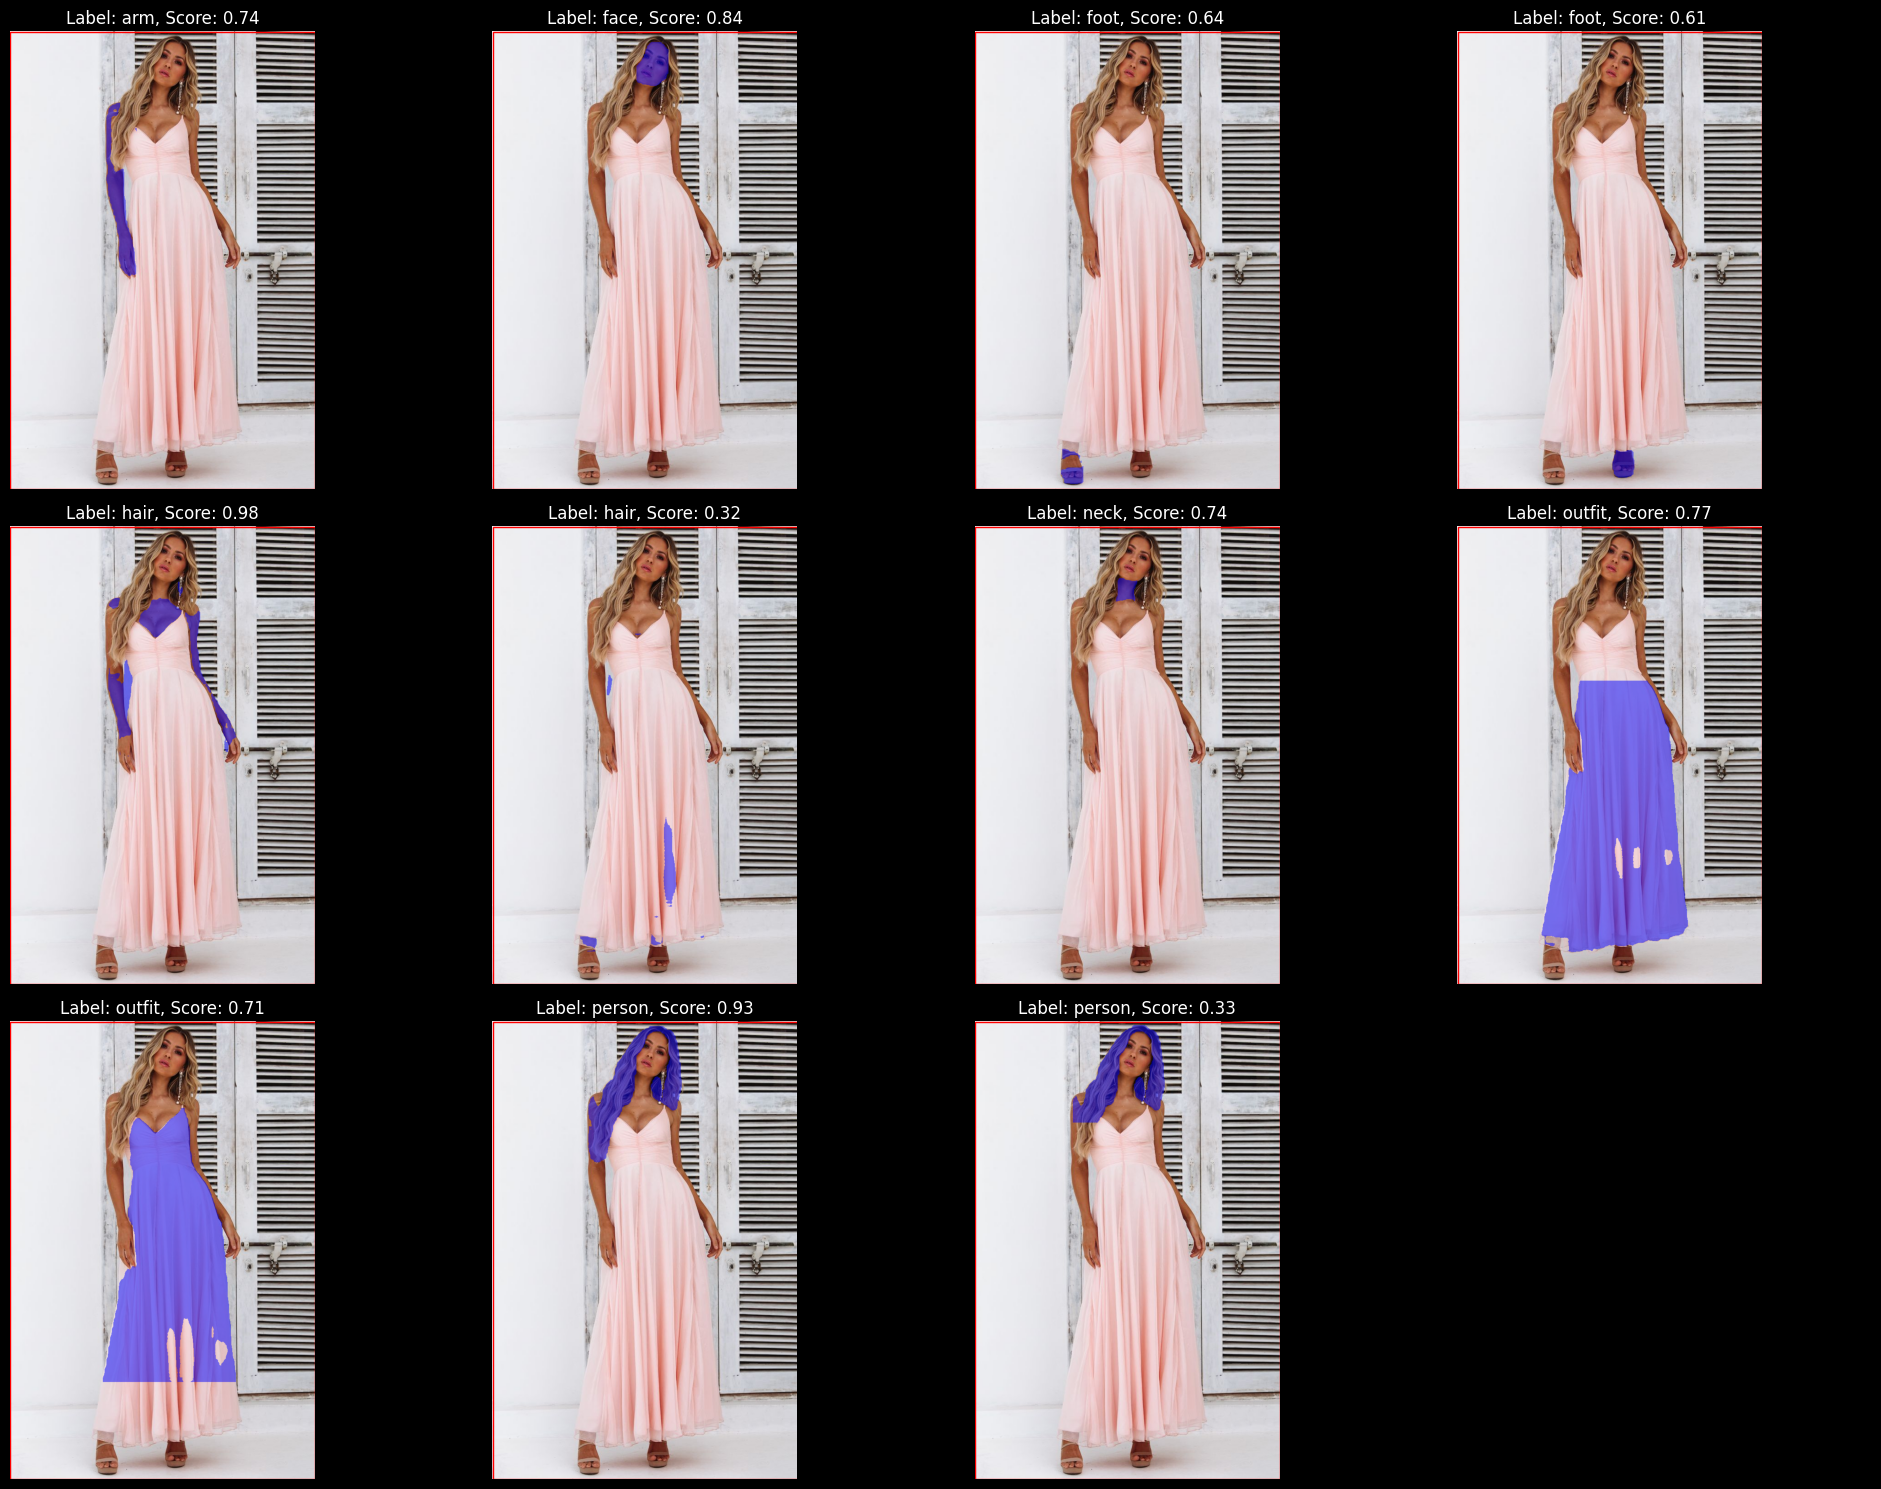

In [41]:
r.display_results()

In [31]:
from utils import resize_image_pil

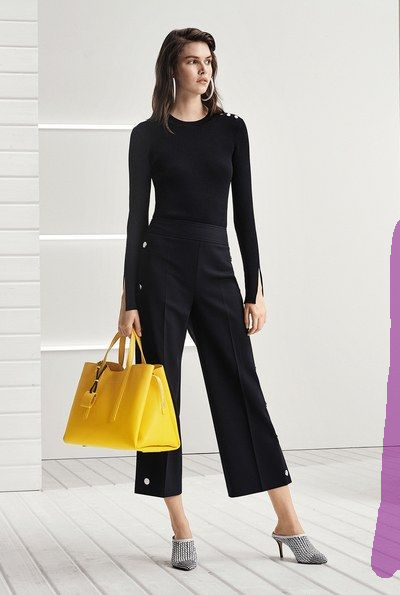

In [34]:
coco_polygons = [ro for ro in row["mask_metadata"] if ro["label"] == "person"][0][
    "polygons"
]
from utils import convert_coco_polygons_to_mask

mask = convert_coco_polygons_to_mask(coco_polygons, 1024, 1024)
mask = Image.fromarray(mask)
# image = resize_image_pil(image)
overlay_mask(image, mask)